In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import Series
from sklearn.feature_selection import f_classif, mutual_info_classif
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-scoring/sample_submission.csv
/kaggle/input/sf-scoring/train.csv
/kaggle/input/sf-scoring/test.csv


In [2]:
rand=42

In [3]:
DATA_DIR = '/kaggle/input/sf-scoring/'
#DATA_DIR = './'
df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [4]:
sample_submission.shape

(36349, 2)

In [5]:
df_test.shape

(36349, 18)

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [7]:
df_train.head(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [8]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [9]:
sample_submission.head(5)

,client_id,default
0,74835,0
1,17527,0
2,75683,0
3,26883,0
4,28862,0


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  36349 non-null  int64
 1   default    36349 non-null  int64
dtypes: int64(2)
memory usage: 568.1 KB


In [11]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [12]:
# основные статистики
data.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.669999,0.085086
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.470215,0.279010
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.000000,0.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.000000,0.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


In [13]:
# количество уникальных значений 
data.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

<AxesSubplot:>

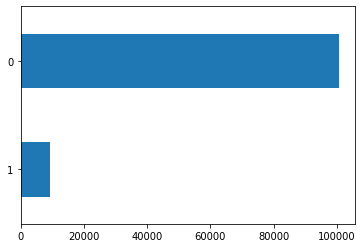

In [14]:
# Построим диаграмму для переменной default
data['default'].value_counts(ascending=True).plot(kind='barh')

In [15]:
# удалим незначащие столбцы
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [16]:
# наличие пропусков
data.isnull().sum(axis=0)

education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

<AxesSubplot:>

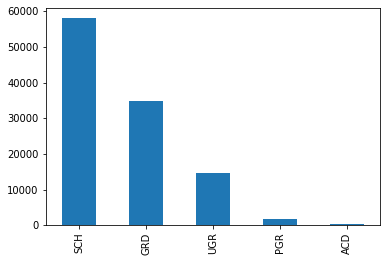

In [17]:
data.education.value_counts().plot.bar()

In [18]:
# Заполним пропуски в столбце education наиболее частым значением 'SCH'
data['education'].fillna('SCH',inplace=True)

## Визуализация

In [19]:
#Построим графики распределения числовых переменных.
#числовые переменные
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
#категориальные переменные
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
#бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


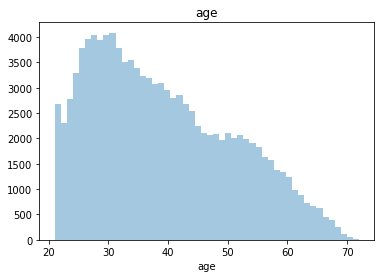

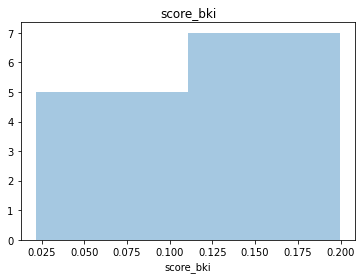

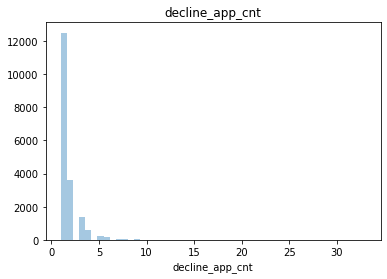

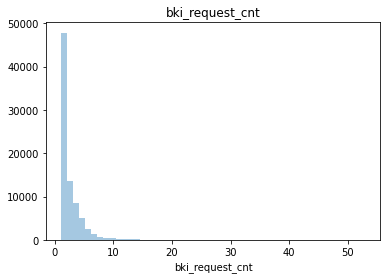

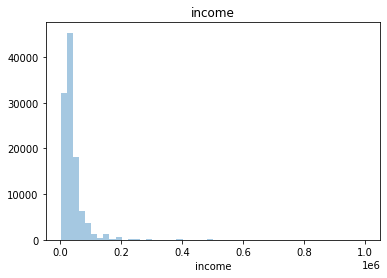

In [20]:
for i in num_cols:
    plt.figure()
    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
    plt.title(i)
    plt.show()

In [21]:
# логарифмируем числовые признаки
#for i in num_cols:
#    data[i] = np.log10(data[i])
#    plt.figure()
#    sns.distplot(data[i][data[i] > 0].dropna(), kde = False, rug=False)
#    plt.title(i)
#    plt.show()

In [22]:
# логарифмируем числовые признаки
data['age'] = np.log(data['age']+1)
data['decline_app_cnt'] = np.log(data['decline_app_cnt']+1)
data['income'] = np.log(data['income']+1)
data['bki_request_cnt'] = np.log(data['bki_request_cnt']+1)

In [23]:
#Нормализация численных данных
from sklearn.preprocessing import StandardScaler

for column in num_cols:
    data[column] = StandardScaler().fit_transform(np.array(data[column].values).reshape(-1, 1))

Построим боксплоты для числовых переменных

<AxesSubplot:xlabel='default', ylabel='age'>

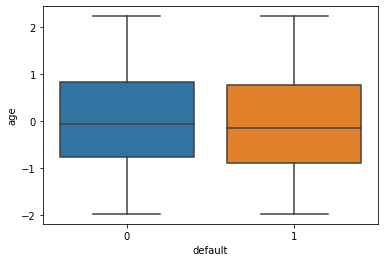

In [24]:
sns.boxplot(x='default',y='age',data=data)

Дефолтные клиенты в среднем младше

<AxesSubplot:xlabel='default', ylabel='bki_request_cnt'>

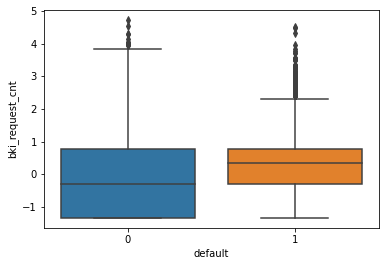

In [25]:
sns.boxplot(x='default',y='bki_request_cnt',data=data)

Дефолтные клиенты в среднем имеют больше запросов в БКИ

<AxesSubplot:xlabel='default', ylabel='income'>

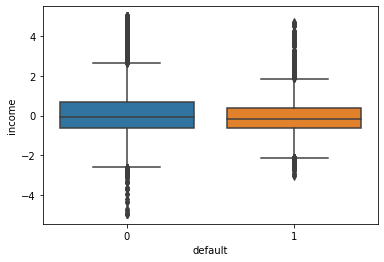

In [26]:
sns.boxplot(x='default',y='income',data=data)

In [27]:
data.groupby('default').income.mean()

default
0    0.013143
1   -0.141327
Name: income, dtype: float64

Дефолтные клиенты в среднем имеют более низкий доход

In [28]:
data.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,GRD,M,-0.888776,Y,Y,-0.418815,0,-0.735587,0.770563,50,1,2,0.680425,1,4,N,0,0
1,SCH,F,0.120447,N,N,4.539989,0,0.800039,0.333797,50,1,2,-2.624624,4,3,N,0,0
2,UGR,M,0.972731,Y,Y,-0.418815,0,0.426908,-0.281790,50,1,2,-0.052834,1,3,Y,0,0
3,SCH,M,1.362924,N,N,-0.418815,0,-0.940432,-0.281790,40,1,2,-0.868125,1,3,N,0,0
4,GRD,F,0.031629,N,N,-0.418815,0,-1.167347,-1.334144,80,2,3,1.937123,1,3,N,0,0


## Значимость непрерывных переменных

<AxesSubplot:>

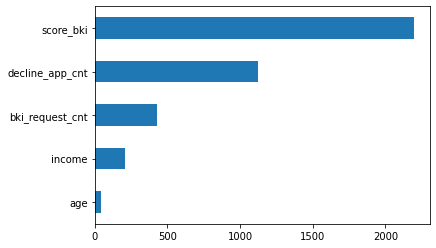

In [29]:
#7. Значимость непрерывных переменных
#В основе метода оценки значимости переменных лежит однофакторный дисперсионный анализ (ANOVA). 
#Основу процедуры составляет обобщение результатов двух выборочных t-тестов для независимых выборок (2-sample t). 
#В качестве меры значимости мы будем использовать значение f-статистики. 
#Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, 
#и тем важнее данный признак для нашей линейной модели.
#числовые переменные

imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

In [30]:
# Заменим значения в столбце education на dummie-переменные
data = pd.get_dummies(data, columns=['education'], dummy_na=False)

In [31]:
# применим  LabelEncoder() для преобразования бинарных и категориальных переменных в цифровой формат
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for column in bin_cols:
    data[column] = le.fit_transform(data[column])
    
#columns = ['first_time', 'sna', 'work_address', 'home_address', 'region_rating']

#for column in columns:
#    data[column] = le.fit_transform(data[column])

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sex               110148 non-null  int64  
 1   age               110148 non-null  float64
 2   car               110148 non-null  int64  
 3   car_type          110148 non-null  int64  
 4   decline_app_cnt   110148 non-null  float64
 5   good_work         110148 non-null  int64  
 6   score_bki         110148 non-null  float64
 7   bki_request_cnt   110148 non-null  float64
 8   region_rating     110148 non-null  int64  
 9   home_address      110148 non-null  int64  
 10  work_address      110148 non-null  int64  
 11  income            110148 non-null  float64
 12  sna               110148 non-null  int64  
 13  first_time        110148 non-null  int64  
 14  foreign_passport  110148 non-null  int64  
 15  sample            110148 non-null  int64  
 16  default           11

In [33]:
data

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,...,sna,first_time,foreign_passport,sample,default,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR
0,1,-0.888776,1,1,-0.418815,0,-0.735587,0.770563,50,1,...,1,4,0,0,0,0,1,0,0,0
1,0,0.120447,0,0,4.539989,0,0.800039,0.333797,50,1,...,4,3,0,0,0,0,0,0,1,0
2,1,0.972731,1,1,-0.418815,0,0.426908,-0.281790,50,1,...,1,3,1,0,0,0,0,0,0,1
3,1,1.362924,0,0,-0.418815,0,-0.940432,-0.281790,40,1,...,1,3,0,0,0,0,0,0,1,0
4,0,0.031629,0,0,-0.418815,0,-1.167347,-1.334144,80,2,...,1,3,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,0.610749,0,0,-0.418815,0,0.225214,0.770563,50,1,...,4,4,0,1,0,0,1,0,0,0
110144,1,0.291609,1,1,-0.418815,0,-0.307360,-0.281790,50,2,...,1,4,0,1,0,0,0,0,1,0
110145,1,-0.662367,0,0,-0.418815,0,0.784750,1.109345,80,2,...,2,2,0,1,0,0,0,0,1,0
110146,0,-0.888776,0,0,-0.418815,1,0.851432,0.770563,50,1,...,2,3,0,1,1,0,0,0,1,0


In [34]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
х = train_data.drop(['default'], axis=1)

In [35]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
from sklearn.model_selection import train_test_split

# выделим 20% данных на валидацию (параметр test_size)
х_train, х_test, y_train, y_test = train_test_split(х, y, test_size=0.2, stratify=y, shuffle=True, random_state=rand)

In [36]:
# проверяем
х_train.shape, х_test.shape, y_train.shape, y_test.shape

((59039, 20), (14760, 20), (59039,), (14760,))

In [37]:
# Импортируем необходимые библиотеки:
from sklearn.linear_model import LogisticRegression # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.model_selection import GridSearchCV

In [38]:
# запускаем GridSearch на небольшом кол-ве итераций max_iter=50 и с достаточно большой дельтой останова tol1e-3
# чтобы получить оптимальные параметры модели в первом приближении
model = LogisticRegression(random_state=rand)

iter_ = 50
epsilon_stop = 1e-3

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
]

## model ваша модель логистической регрессии
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
gridsearch.fit(х_train, y_train)
model = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1360, in fit
    sample_weight=sample_weight)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py", line 931, in _fit_liblinear
    y=y)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py", line 72, in inner_f
    return f(**kwargs)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/utils/class_weight.py", line 64, in compute_class_weight
    " got: %r" % class_weight)
ValueError: class_weight must be dict, 'balanced', or None, got: 'none'

  FitFail

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False


C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 50
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'newton-cg'
	tol: 0.001
	verbose: 0
	warm_start: False

In [39]:
model = LogisticRegression(tol=0.001,solver='newton-cg', max_iter=50, class_weight='balanced', random_state=rand)
model.fit(х_train, y_train)
y_pred = model.predict(х_test)

In [40]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
classification_report = classification_report(y_test, y_pred, target_names=target_names)
print(classification_report)

              precision    recall  f1-score   support

     class 0       0.93      0.66      0.77     12886
     class 1       0.22      0.67      0.34      1874

    accuracy                           0.66     14760
   macro avg       0.58      0.67      0.56     14760
weighted avg       0.84      0.66      0.72     14760



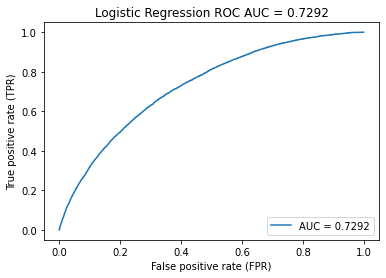

In [41]:
# Отрисовать ROC кривую
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score,confusion_matrix
from matplotlib import pyplot as plt

# Посчитать значения ROC кривой и значение площади под кривой AUC
fpr, tpr, thresholds = roc_curve(y_train,model.predict_proba(х_train).T[1])
roc_auc = roc_auc_score(y_train,model.predict_proba(х_train).T[1])   
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.legend(loc = 'lower right')

In [42]:
#Построение матрицы ошибок
print('confusion_matrix:')
print(confusion_matrix(y_test,y_pred))

confusion_matrix:
[[8539 4347]
 [ 618 1256]]


In [43]:
#обучаем финальную модель на всех обучающи данных
model_final = LogisticRegression(tol=0.001,solver='newton-cg', max_iter=50, class_weight='balanced', random_state=rand)
model_final.fit(х, y)

LogisticRegression(class_weight='balanced', max_iter=50, random_state=42,
                   solver='newton-cg', tol=0.001)

In [44]:
predict_submission = model_final.predict(test_data)

In [45]:
sample_submission['default'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,client_id,default
0,74835,0
1,17527,1
2,75683,0
3,26883,0
4,28862,0
5,99881,1
6,26630,1
7,79934,0
8,16605,0
9,105449,0


In [46]:
sample_submission.describe()

,client_id,default
count,36349.000000,36349.000000
mean,54945.647473,0.378387
std,31706.052195,0.484992
min,4.000000,0.000000
25%,27744.000000,0.000000
50%,54657.000000,0.000000
75%,82322.000000,1.000000
max,110148.000000,1.000000


In [47]:
!kaggle competitions submit -c sf-scoring -f ssubmission.csv -m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'

Traceback (most recent call last):
  File "/opt/conda/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/lib/python3.7/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/lib/python3.7/site-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
